In [1]:
import math 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import re, string, unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from  utilities import convert_to_float,text_to_list,list_to_text,unique_labels
from utilities import *
%matplotlib inline
sns.set()
plt.style.use("ggplot")


In [2]:
# Loading dataframe
outbreaks = pd.read_csv("cleaned_outbreaks.csv")
#General information about the dataframe
outbreaks= outbreaks.reset_index()
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19984 entries, 0 to 19983
Data columns (total 11 columns):
index               19984 non-null int64
Year                19984 non-null int64
Month               19984 non-null object
State               19984 non-null object
Species             13195 non-null object
Location            18831 non-null object
Food                10499 non-null object
Illnesses           19984 non-null float64
Hospitalizations    16338 non-null float64
Fatalities          16372 non-null float64
normalized_food     10499 non-null object
dtypes: float64(3), int64(2), object(6)
memory usage: 1.7+ MB


In [ ]:
outbreaks.head()

In [4]:
# Sorted list of null values
null_values= outbreaks.isnull().sum().sort_values(axis=0, ascending=True)
# Percent of not null values by column
percent_null_values= 100.0*null_values/outbreaks.shape[0]
percent_not_null_values = round(100.0- percent_null_values)
pd.DataFrame(percent_not_null_values,columns=['Percent_NaN_values'])

,Percent_NaN_values
index,100.0
Year,100.0
Month,100.0
State,100.0
Illnesses,100.0
Location,94.0
Fatalities,82.0
Hospitalizations,82.0
Species,66.0
Food,53.0


In [ ]:
outbreaks=outbreaks[['index', 'Year', 'Month', 'State', 'Species', 'Location', 'normalized_food','Illnesses', 'Hospitalizations', 'Fatalities']]
outbreaks.head()

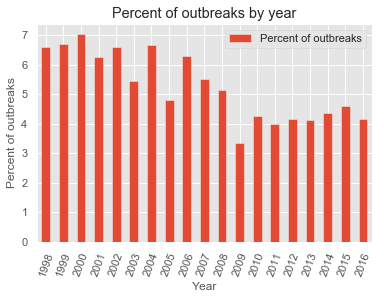

In [6]:
# Distribution of outbreaks  with respect to years.
outbreaks_byyear=outbreaks.groupby(['Year'])[['Illnesses']].count()
outbreaks_byyear.rename(columns={'Illnesses':"Percent of outbreaks"},inplace=True)
# Percent of outbreaks by year
percent_outbreaks_byyear =100.0*outbreaks_byyear/outbreaks.shape[0]
# Plot
percent_outbreaks_byyear.plot(kind='bar',rot=70,label=None)
plt.title("Percent of outbreaks by year")
plt.ylabel('Percent of outbreaks')
plt.show()

The total number of outbreaks decrease with the years. 

Here we have 5 features that have null values. Let us check outbreaks where 80% of the features have null values. In our case 80% represent 4 missing values.

In [ ]:
# 80% of missing values  or more
too_many_nulls=outbreaks[((outbreaks.isnull().sum(axis=1))>=4)]
too_many_nulls.head()
    

Dataframe for outbreaks where 80% or more features \
have null values.

In [8]:
percent_80__nulls=100.0*too_many_nulls.shape[0]/outbreaks.shape[0]
print("The percent of outbreaks where 80% or more features \
have null values is: {:.1f}%.".format(percent_80__nulls))

The percent of outbreaks where 80% or more features have null values is: 4.3%.


Distribution of null values over the years.

In [9]:
#Dataframe grouped by year with all outbreaks where 80% or more features have null values.
too_many_nulls_byyear=too_many_nulls.groupby(['Year'])[['Illnesses']].count()
#Renaming column Illnesses
too_many_nulls_byyear.rename(columns={'Illnesses':"Percent of outbreaks"},inplace=True)
# Percent of outbreaks by year
percent_many_nulls_byyear =100.0*too_many_nulls_byyear/too_many_nulls.shape[0]

Percent of outbreaks where 80% or more features  have null values normalized 
by total number of outbreaks grouped by year.

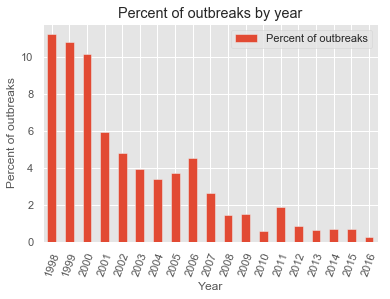

In [10]:
normalize_many_nulls_byyear=100.0*too_many_nulls_byyear/outbreaks_byyear
normalize_many_nulls_byyear.plot(kind='bar',rot=70,label=None)
plt.title("Percent of outbreaks by year")
plt.ylabel('Percent of outbreaks')
plt.show()

The percentage of outbreaks that have many null values decreases over the years. This could be associated 
with the improvement in the collection and reporting of data to the CDC.

So, let us consider only the outbreaks with less than 80% null values.

In [11]:
outbreaks=outbreaks[~((outbreaks.isnull().sum(axis=1))>=4)]

In [ ]:
outbreaks.info()

Let us analyze the distribution of this type of outbreaks with the months.

In [13]:
outbreaks_bymonth=outbreaks.groupby(['Month'])[['Illnesses']].count()
#Renaming column Illnesses
outbreaks_bymonth.rename(columns={'Illnesses':"Number of outbreaks"},inplace=True)


In [ ]:
percent_outbreaks_bymonth=100.0*outbreaks_bymonth/outbreaks_bymonth['Number of outbreaks'].sum()
# Sorted months
percent_outbreaks_bymonth=percent_outbreaks_bymonth.reindex(['January', 'February', 'March', 'April', 'May', 'June', 
                          'July', 'August', 'September', 'October', 'November', 'December'])

percent_outbreaks_bymonth.plot(kind='bar',rot=70,label=None)
plt.title("Outbreaks by month")
plt.ylabel('Percent of outbreaks')
plt.show()

To treat the null values  let us  work with each feature separately. 

In [15]:
def fill_nulls(dataframe,column):
    #Return:
    # column  with null values filled.
    if dataframe[column].isnull().sum()>0:
        fill_back= dataframe[column].fillna(method='bfill')
        fill_foward= fill_back.fillna(method='ffill')
        return fill_foward
    return dataframe[column]
    

In [16]:
for column in outbreaks.columns:
    outbreaks.loc[:,column]=fill_nulls(outbreaks,column)
    

In [ ]:
outbreaks.info()

In [18]:
# Stadistical figures for column illnesses
median = outbreaks.Illnesses.median()
quant_3 = np.percentile(outbreaks.Illnesses,75)
quant_1 = np.percentile(outbreaks.Illnesses,25)
print("1-quantile for illnesses: {:.1f}".format(quant_1))
print("Median for illnesses: {:.1f}".format(median))
print("3-quantile for illnesses: {:.1f}".format(quant_3))

1-quantile for illnesses: 3.0
Median for illnesses: 8.0
3-quantile for illnesses: 19.0


In [19]:
def plot_numeric_column(dataframe,column,center=0.0,is_log=False,bins=25):
    # Parameters:
    
    # dataframe: Dataframe of study
    # column: Column to plot
    # center: Center on x axis
    # is_log:  Here, True mean that log of column is ploted
    # bins: Number of bins in the histogram
    
    #Return:
    #Plot of dataframe[column]
    
    fig= plt.figure(figsize=(12,8))
    axes= fig.add_axes([0,0,0.9,0.9])
    
    if is_log:
        plot_column=np.log(dataframe[column]+center)
        log_median = plot_column.median()
        log_quant_3 = np.percentile(plot_column,75)
        log_quant_1 = np.percentile(plot_column,25)
        
        plt.axvline(x=log_quant_1, label = "log of 1-quantile",c="green",alpha = 0.6)
        plt.axvline(x=log_median, label = "log of median",c="k",alpha = 0.6)
        plt.axvline(x=log_quant_3,label = "log of 3-quantile",c="blue",alpha = 0.6)
        
        
        axes.hist(plot_column,log=True,bins=bins,label=None)
        plt.title('Distribution of Log of '+ column)
        plt.xlabel('Log of '+ column)
       
    else:
        plot_column=dataframe[column]+center
        median = plot_column.median()
        quant_3 = np.percentile(plot_column,75)
        quant_1 = np.percentile(plot_column,25)
        
        axes.axvline(x=quant_1, label = "1-quantile",c="green",alpha = 0.6)
        axes.axvline(x=median, label = "median",c="k",alpha = 0.6)
        axes.axvline(x=quant_3,label = "3-quantile",c="blue",alpha = 0.6)
        
        
        axes.hist(plot_column,log=True,bins=bins,label=None)
        plt.title('Distribution of '+ column)
        plt.xlabel(column)
     
    plt.ylabel('Frecuency(Log Scale)')
    plt.legend()
    plt.show()
        

In [ ]:
# Let us plot an histogram of Illnesses
plot_numeric_column(outbreaks,'Illnesses',center=0.0,is_log=False,bins=25)

Illnesses in log scale.

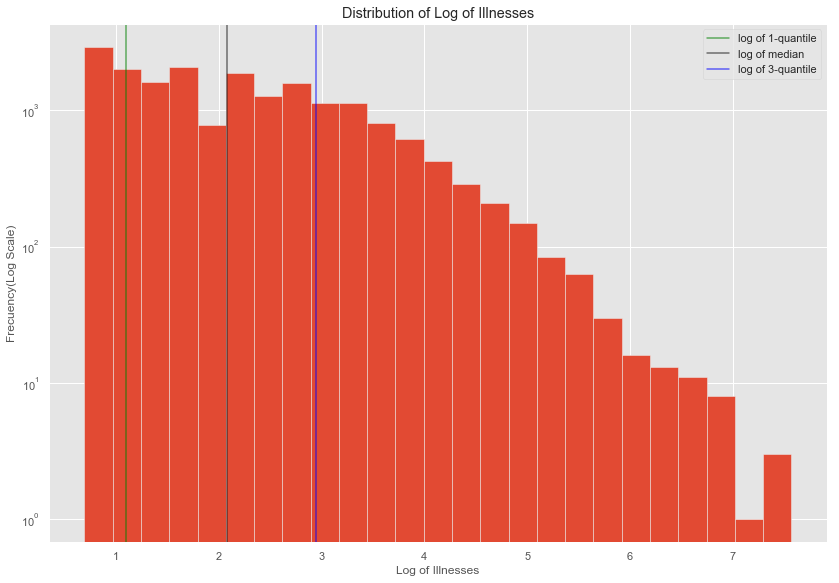

In [21]:
# Let us plot an histogram of log of Illnesses
plot_numeric_column(outbreaks,'Illnesses',center=0.0,is_log=True,bins=25)

Half of bell shape

In [22]:
no_hospitalizations=100.0*(outbreaks.Hospitalizations == 0.0).sum()/outbreaks.Hospitalizations.shape[0]
with_hospitalizations=100.0*(outbreaks.Hospitalizations > 0.0).sum()/outbreaks.Hospitalizations.shape[0]

print("Percent of outbreaks that does not produce hospitalizations {:.1f} %".format(no_hospitalizations))
print("")
print("Percent of outbreaks that produce hospitalizations {:.1f} %".format(with_hospitalizations))

Percent of outbreaks that does not produce hospitalizations 72.3 %

Percent of outbreaks that produce hospitalizations 27.7 %


In the case of Hospitalizations and fatalities 

In [ ]:
# Let us plot an histogram of Hospitalizations
plot_numeric_column(outbreaks,'Hospitalizations',center=1.0,is_log=False,bins=25)

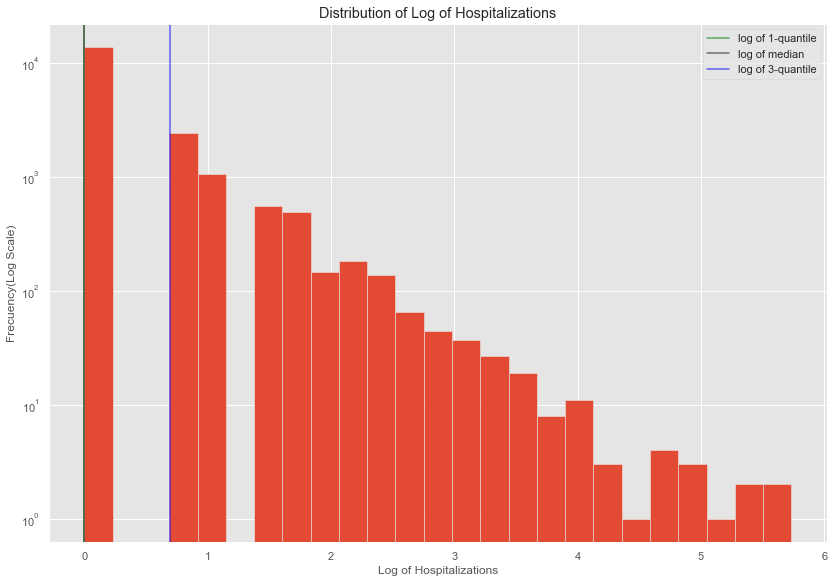

In [24]:
# Let us plot an histogram of log Hospitalizations+1
plot_numeric_column(outbreaks,'Hospitalizations',center=1.0,is_log=True,bins=25)

Here we have a lot of cases with zero hospitalizations not many outbreaks with one or more hospitalizations(in fact they are at the rate of $75/25$)  that mimics a Pareto distribution. Let us analyze the feature fatalities.

In [25]:
no_fatalities=100.0*(outbreaks.Fatalities == 0.0).sum()/outbreaks.Fatalities.shape[0]
with_fatalities=100.0*(outbreaks.Fatalities > 0.0).sum()/outbreaks.Fatalities.shape[0]

print("Percent of outbreaks that not produce fatalities {:.1f} %".format(no_fatalities))
print("")
print("Percent of outbreaks that produce fatalities {:.1f} %".format(with_fatalities))

Percent of outbreaks that not produce fatalities 98.6 %

Percent of outbreaks that produce fatalities 1.4 %


In [ ]:
# Let us plot an histogram of Fatalities+1
plot_numeric_column(outbreaks,'Fatalities',center=1.0,is_log=False,bins=15)

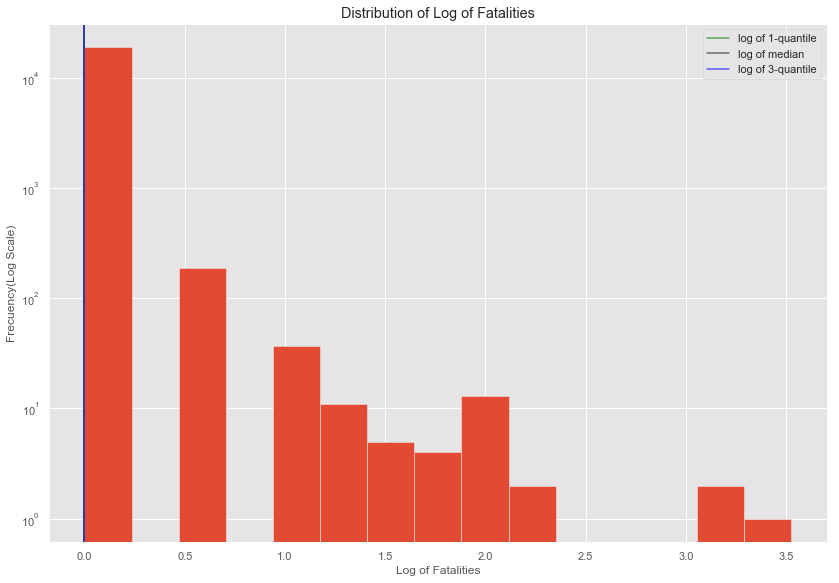

In [27]:
# Let us plot an histogram of log Fatalities+1
plot_numeric_column(outbreaks,'Fatalities',center=1.0,is_log=True,bins=15)

Here we can see that the outbreaks with fatalities are very rare. The rate of deaths vs  not deaths is  $99/1$. So, essentially we have two classes: outbreaks with deaths and outbreaks without them.

Half of bell shape

As most outbreaks do not generate hospitalizations, let us  divide the dataset in two categories: outbreaks with hospitalizations and outbreaks without them.

In [28]:
def two_classes(dataframe, column,thr=0.0):
    #Params:
    # Here thr is threshold that define the classes
    binary_classes= (dataframe[column] > thr).astype("int")
    return binary_classes

In [ ]:
# For hospitalizations the threshold =0.0
outbreaks["Are_there_Hospitalizations"] = two_classes(outbreaks, "Hospitalizations",thr=0.0)
# Like hospitalizations, let us define  threshold =0.0 for fatalities
outbreaks["Are_there_Fatalities"] = two_classes(outbreaks,"Fatalities", 0.0)
outbreaks.head()


Is there any kind of correlation between the numerical variables of our dataset?

In [58]:
correlation_matrix =outbreaks[['Illnesses', 'Hospitalizations', 'Fatalities']].corr()
correlation_matrix

,Illnesses,Hospitalizations,Fatalities
Illnesses,1.000000,0.355801,0.073564
Hospitalizations,0.355801,1.000000,0.364520
Fatalities,0.073564,0.364520,1.000000


In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, vmin=0, vmax=1)
plt.show()

Here one can note that, although weak, there is a certain relationship between the variables hospitalization and Illnesess. Also, the same phenomena occur between hospitalization and fatalities. Although, the correlation between Illnesses and fatalities is very weak, maybe  it is  because they are related in a non-linear way.

Let's see if Illnesses determines whether an outbreak produces hospitalizations or not.
In order to do that, let us transform Illnesses to  logarithmic scale



In [32]:
outbreaks['Log_Illnesses']=np.log(outbreaks.Illnesses)

Let's see if  there is some  statistically difference  between outbreaks with hospitalizations and those that do not produce them. Also, let's explore whether outbreaks with deaths behave differently than those that do cause deaths.

In [ ]:
# Log of Illnesses when there are not hospitalizations.
Log_Illnesses_Hosp =outbreaks['Log_Illnesses'][outbreaks.Are_there_Hospitalizations==1.0]

# Log of Illnesses when there are hospitalizations.
Log_Illnesses_no_Hosp= outbreaks['Log_Illnesses'][outbreaks.Are_there_Hospitalizations==0.0]

plt.figure(figsize=(12,8))
# Illnesses with hospitalizations
plt.hist(Log_Illnesses_Hosp,log=True,label='Hospitalization')

#Illnesses without hospitalizations
plt.hist(Log_Illnesses_no_Hosp,log=True,label='No_Hospitalization',alpha=0.6)

#Labels
plt.title('Count of Illnesses(log scale) vs hospitalization')
plt.xlabel('Log of Illnesses')
plt.ylabel('Frecuency(Log scale)')
plt.legend()
plt.show()

Now, for the case of the feature fatalities.

In [ ]:
# Log of Illnesses when there are not hospitalizations.
Log_Illnesses_with_Fatalities =outbreaks['Log_Illnesses'][outbreaks.Are_there_Fatalities==1.0]

# Log of Illnesses when there are hospitalizations.
Log_Illnesses_no_Fatalities =outbreaks['Log_Illnesses'][outbreaks.Are_there_Fatalities==0.0]

plt.figure(figsize=(12,8))
# Illnesses with fatalities
plt.hist(Log_Illnesses_with_Fatalities,log=True,label='Fatalities')
#Illnesses without fatalities
plt.hist(Log_Illnesses_no_Fatalities,log=True,label='No_Fatalities',alpha=0.6)
#Labels
plt.title('Count of Illnesses(log scale) vs fatalities')
plt.xlabel('Log of Illnesses')
plt.ylabel('Frecuency(Log scale)')
plt.legend()
plt.show()

Boxplot graphs

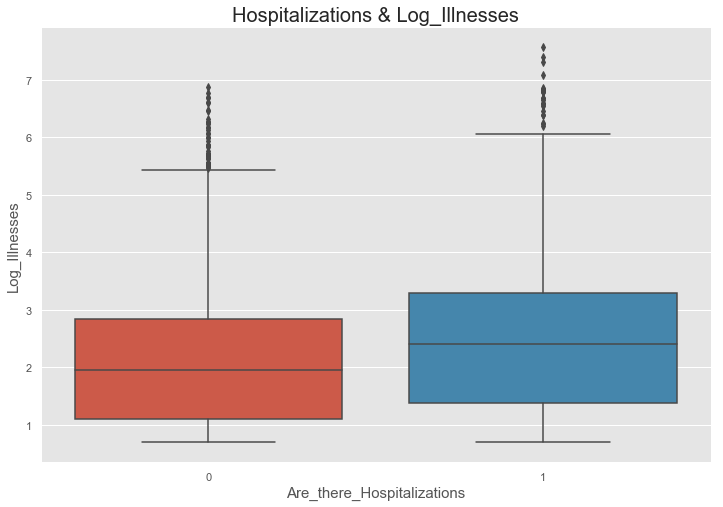

In [35]:
plt.figure(figsize=(12,8))
#Boxplot for Hospitalizations
sns.boxplot(x='Are_there_Hospitalizations', y='Log_Illnesses', data=outbreaks)
#Labels
plt.xlabel('Are_there_Hospitalizations',fontsize = 15)
plt.ylabel('Log_Illnesses',fontsize = 15)
plt.title('Hospitalizations & Log_Illnesses', fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
#Boxplot for fatalities
sns.boxplot(x='Are_there_Fatalities', y='Log_Illnesses', data=outbreaks)
#Labels
plt.xlabel('Are_there_Fatalities',fontsize = 15)
plt.ylabel('Log_Illnesses',fontsize = 15)
plt.title('Fatalities & Log_Illnesses', fontsize=20)
plt.show()

Although above histograms do not seem to give a definitive answer, 
boxplots seem to show a difference between 
outbreaks with hospitalizations and those that do not produce hospitalizations.
One can approach this question through hypothesis test methods.
In this case our test statistic is the difference of median of  illnesses between outbreaks with hospitalizations and without hospitalizations , in other words, we need to check if the observed difference is statistically significant or it is just by chance. Then, in this case, two-sample test is an appropriate method.

$H_{0}$: Null hypothesis there is not difference  $median_{hosp} = median_{no\_hosp}$

$H_{a}$: Alternative hypothesis there is a difference  $median_{hosp} \neq median_{nohosp}$
Here, Illnesses distribution is very biased, then, the t-test classic method it is not appropriate. Instead, let's use hack methods.

In [37]:
def permutation_sample(data1, data2):
    """Return a permutation sample from two data sets."""

    # Concatenate the data sets:
    data = np.concatenate((data1, data2))

    # Randonly permute the concatenated array:
    permuted_data = np.random.permutation(data)

    # Separate the new array into two samples:
    permuted_sample_1 = permuted_data[:len(data1)]
    permuted_sample_2 = permuted_data[len(data1):]

    return permuted_sample_1, permuted_sample_2


def draw_permutation_replicates(data_1, data_2, function, size=1):
    #Draw multiple permutation replicates

    # Initialize array of permutation replicates:
    permutation_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation samples:
        permutation_sample_1, permutation_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic:
        permutation_replicates[i] = function(permutation_sample_1, permutation_sample_2)

    return permutation_replicates

def two_sample_test(data1,data2,test_statistic,number_of_replicates):
    np.random.seed(12)
    # test statistic of our two sample test
    our_sample_difference = test_statistic(data1,data2)
    # Generate a list of replicates 
    permutation_replicates = draw_permutation_replicates(data1, data2, test_statistic, size=number_of_replicates)
    
    # Compute fraction of replicates that are greater than the observed test statistic
    p = np.sum(permutation_replicates >= our_sample_difference) / len(permutation_replicates)
    # return the p-value
    return p

def difference_of_medians(data_1, data_2):
    #Return the difference in medians of two arrays

    # The difference of means of data_1, data_2:
    return np.median(data_1) - np.median(data_2)

In [38]:
# P-value for test statistic associated to 

print("P-values:{}".format(two_sample_test(Log_Illnesses_Hosp,Log_Illnesses_no_Hosp,difference_of_medians,1000)))

P-values:0.0


In [39]:
# P-value for test statistic associated to 
print("P-values:{}".format(two_sample_test(Log_Illnesses_Hosp,Log_Illnesses_no_Hosp,difference_of_medians,10000)))


P-values:0.0


This low P-value favors the alternative hypothesis. Then, statistically there is difference between outbreaks with hospitalizations and those that 
do not cause them. The same conclusion is valid for the feature fatalities.
In other words, one can determine if an outbreak produces hospitalizations(fatalities) if we know number of Illnesses.

In this dataset there are  several categorical features, e.g., species, location, etc. 
For each column, let's see  the number of outbreaks per label.

In [40]:
import copy

def sort_by_frecuency(data,column):
    # Params:
    # data is a dataframe
    # column is a column of data
    
    # Return:
    # Sorted dataframe with percent of outbreaks per label
    
    # Here, I use deepcopy to keep the original dataframe(outbreaks) unchanged
    dataframe = copy.deepcopy(data)
    # Number of outbreaks for the set of labels of column
    outbreaks_column = pd.pivot_table(dataframe, index=column, values='Illnesses', aggfunc='count')
    #Sorting
    sorted_by_column= outbreaks_column.sort_values(by="Illnesses",axis=0, ascending=False)
    # Percent of outbreaks per label
    percent_outbreaks_by_column= 100.0*sorted_by_column/sorted_by_column['Illnesses'].sum()
    # Renaming the column
    percent_outbreaks_by_column.columns = ["%_of_outbreaks"]
    return percent_outbreaks_by_column

In [41]:
categorical_columns= ['State', 'Species', 'Location','normalized_food']
for column in categorical_columns:
    print("-------------------------------------------------------------------------------------------")
    print('In {} there are {} unique labels'.format(column,sort_by_frecuency(outbreaks,column).count()[0]))
    print("-------------------------------------------------------------------------------------------")
    print("")
    print(sort_by_frecuency(outbreaks,column)[:15])
    print("")
    print('Total contribution of top 15 values: {:.2f}%.'.format(sort_by_frecuency(outbreaks,column)[:15].sum()[0],2))
    print("")
    print("")
    

-------------------------------------------------------------------------------------------
In State there are 54 unique labels
-------------------------------------------------------------------------------------------

           %_of_outbreaks
State                    
FL              12.409827
CA              12.226869
OH               6.821746
IL               5.948772
NY               4.626242
MN               4.579195
WA               4.453738
MI               4.197595
MD               3.878725
CO               2.796654
OR               2.671197
PA               2.488238
WI               2.357554
MUL_STATE        1.975954
GA               1.960272

Total contribution of top 15 values: 73.39%.


-------------------------------------------------------------------------------------------
In Species there are 192 unique labels
-------------------------------------------------------------------------------------------

                                          %_of_outbreaks
Species 

In [42]:
def plot_categorical_column(data,column,bins=25):
    
    # Return:
    # Histogram with the percent of outbreaks for each label(top ten)
    
    #I use deepcopy to keep the original dataframe(outbreaks) unchanged
    dataframe = copy.deepcopy(data)
    
    # Top ten labels with most outbreaks
    dist_labels_top_ten=sort_by_frecuency(dataframe,column).head(10)
    # Reset index
    dist_labels_top_ten.reset_index(inplace=True)
    # Bar plot
    bars=sns.catplot(x=column, y="%_of_outbreaks", kind="bar", data=dist_labels_top_ten);
        
    # Rotating labels 
    loc, labels = plt.xticks()
    bars.set_xticklabels(labels, rotation=75)
    # Title
    plt.title('Distribution of the top ten labels of ' + column )
    
    

In [ ]:
#Bar plots for categorical features
categorical_columns= ['State', 'Species', 'Location','normalized_food']
for column in categorical_columns:
    plot_categorical_column(outbreaks,column,bins=25)

As we can see above , for  the case of Species and Location most outbreaks are caused by a few values of these features. Then, in this study, one can convert features such as Species  into a new one where the labels that produce the most outbreaks are kept and the rest are grouped under a new label.

In [44]:
def most_common(data, column,n_classes=15):
    # Take a column from data and transform that column to a new one where  
    # labels that produce the most outbreaks are kept 
    # and the rest are grouped under a new label.
    
    #Params:
    # data is the dataframe and  column is the  column to transform
    #n_classes is the number of labels to keep 
    
    #Return:
    # Column with n_classe + 1 labels
    
    #I use deepcopy to keep the original dataframe(outbreaks) unchanged
    dataframe = data.copy()
    # List of top n_classes labels
    top_classes=list(dataframe[column].value_counts().index)[:n_classes]
    
    def common_classes(element):
        # Take a label and return the same label if label is in the top else rename it to "bulk_" + column
        
        if element in top_classes:
            return element 
        else:
            return "bulk_" + column
    # New column  
    most_common_elements =dataframe[column].apply(common_classes)
    return most_common_elements

Now,as I did in the case of numeric features let us explore if Location and Species are  correlated to hospitalizations. Are they good predictors of hospitalizations? We know that $26$% of all outbreaks cause hospitalizations. In other words, If we randomly select an entry in our dataset, the probability that this observation causes hospitalizations is $26$%. This value is going to define our base model. 
If we know the location or the species would it change this probability?

In [45]:
def classes_percent(data,column,target, month=False):
    #Dataframe with percent of outbreaks per label that produce hospitalizations or fatalities
    
    #Params:
    # data is the dataframe
    # column is the column
    # target is the column that defines our baseline, in our case is 
    # "Are_there_Hospitalizations" or "Are_there_Fatalities"
    
    # Return:
    #Percent of outbreaks per label that produce hospitalizations or fatalities
    
    #deepcopy to keep the original dataframe(outbreaks) unchanged
    dataframe =copy.deepcopy(data)
    # new dataframe with columns to use
    outbreaks_our_columns = dataframe[[column,target,'Illnesses']]
    # Dataframe with count of outbreaks  per label for each value of the target column
    outbreaks_each_class= pd.DataFrame(outbreaks_our_columns.
                                       groupby([column,target]).Illnesses.count())
    #Renaming columns
    outbreaks_each_class.columns = ["Count"]
    # If column = month sort them  according to calendar 
    if month:
        outbreaks_each_class_sorted=outbreaks_each_class.reindex(['January', 'February', 'March', 'April', 'May', 'June', 
                          'July', 'August', 'September', 'October', 'November', 'December'],level=0)
    else:
        outbreaks_each_class_sorted =copy.deepcopy(outbreaks_each_class)
    # Values of target  become the columns of the dataframe
    unstack_each_class= outbreaks_each_class_sorted.unstack().fillna(0.0)
    #Renaming columns
    unstack_each_class.columns =["Class_zero","Class_non_zero"]
    # From counting to percent 
    unstack_each_class_percent=pd.DataFrame(round(100.0*unstack_each_class["Class_non_zero"]/unstack_each_class\
                                                  .sum(axis = 1),2),columns=["Class_non_zero"])
    # Sorting by percent 
    unstack_each_class_percent.sort_values(by="Class_non_zero", ascending=0,inplace=True)
    
    return  unstack_each_class_percent 
    
    

In [46]:
def baseline(data,target):
    # target is the column that defines our baseline, in our case is 
    # "Are_there_Hospitalizations" or "Are_there_Fatalities"
    
    # Return:
    # float  number representing the percentage of hospitalizations or deaths
    
    #deepcopy to keep the original dataframe(outbreaks) unchanged
    dataframe =copy.deepcopy(data)
    return pd.DataFrame(100.0*data[target].value_counts()
                        /data[target].value_counts().sum()).loc[1.0,target]

In [47]:
# Columns to explore
features = ["Location", "Species",'normalized_food', "State"]
# Target
target = "Are_there_Hospitalizations"

print("Percent of outbreaks that cause hospitalization {}%"\
      .format(round(baseline(outbreaks,target),2)))

Percent of outbreaks that cause hospitalization 27.66%


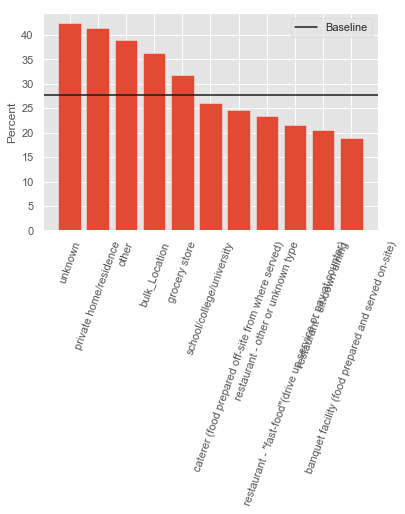

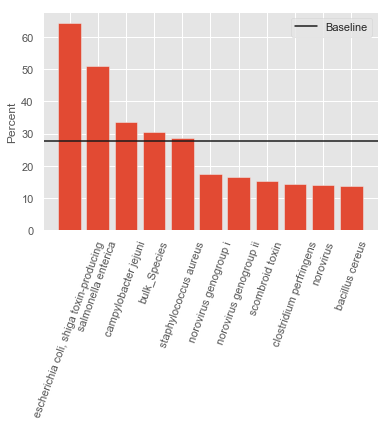

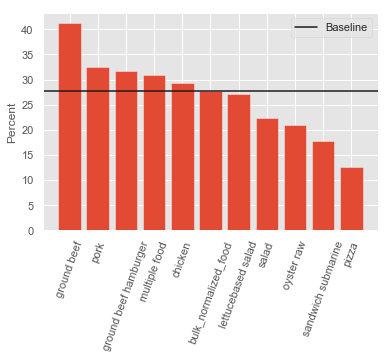

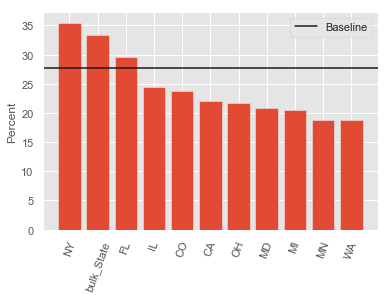

In [48]:
baseline = baseline(outbreaks,target)

for feature in features:
    #deepcopy to keep the original dataframe(outbreaks) unchanged
    data =copy.deepcopy(outbreaks)
    # Creating new columns with most common labels
    data["Most_common_" +feature] = most_common(data, feature,n_classes=10)
    # Percent of outbreaks per label that produce hospitalizations 
    percent= classes_percent(data,"Most_common_" +feature,target, month=False)
    # Baseline line
    
    plt.axhline(y=baseline, color = 'k',label ="Baseline")
    # Barplot of the feature 
    plt.bar(percent.index, percent.Class_non_zero.values)
    # Plot labels
    plt.ylabel("Percent")
    #plt.title('Percent of outbreaks for each' + feature + ' label with Hospitalizations')
    plt.legend()
    plt.xticks(rotation=70)
    plt.show()

As we can see, in general,  the features  Locations and  Species  are not too bad indicators that if a given  outbreak is going to have Hospitalizations or not. Let us check the column Month.

In [ ]:
percent= classes_percent(outbreaks,'Month',target, month=True)
plt.axhline(y=baseline, color = 'k',label ="Baseline")
plt.bar(percent.index, percent.Class_non_zero.values)
plt.ylabel("Percent")
plt.title("Percent of outbreaks with Hospitalizations")
plt.legend()
plt.xticks(rotation=70)
plt.show()

It seems that knowing only the month or the State in which the outbreak occurred are not useful in predicting whether there were hospitalizations(at least compared with other features). 

In [50]:
features = ["Location", "Species"]
for feature in features:
    # Creating new columns with most common labels
    outbreaks["Most_common_" +feature] = most_common(outbreaks, feature,n_classes=10)

In [ ]:
outbreaks.head()

Since our data is like-Pareto distributed the threshold that we would chose can not be too restrictive. Otherwise, we will lose valuable information in the class that describes the outbreaks that generate hospitalizations. Here we will consider a threshold of 99.9.

In [52]:
def outliers_by_month(column,percentile=99.9):
    # Plot of number of outbreaks by month and threshold  line 
    
    #Params:
    # column
    # percentile is our threshold, all datapoints greater than this value are considered outliers
    
    #Return:
    # Plot of number of outbreaks by month and threshold  line 
    
    # Plot
    sns.catplot(x="Month", y=column,jitter=0.2,height=5.0, aspect=7/5.0,data=outbreaks)
    # Threshold  line 
    plt.axhline(y=np.percentile(outbreaks[column],percentile), linewidth=0.8, color = 'red',label = "99.9 percentile")
    #plot labels
    plt.xticks(rotation=70)
    plt.xlabel(column)
    plt.ylabel("Count")
    
    plt.legend()

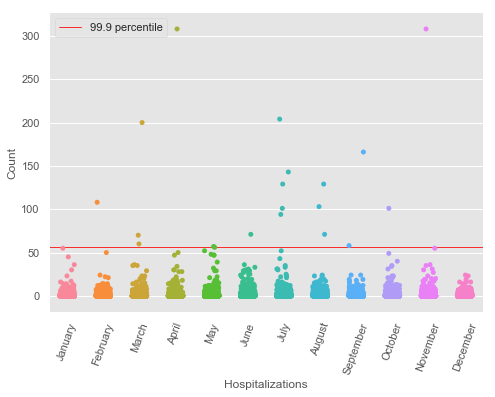

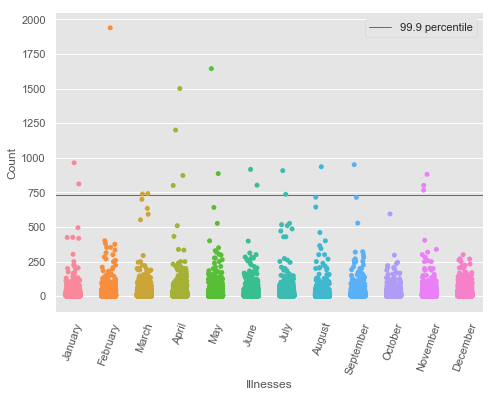

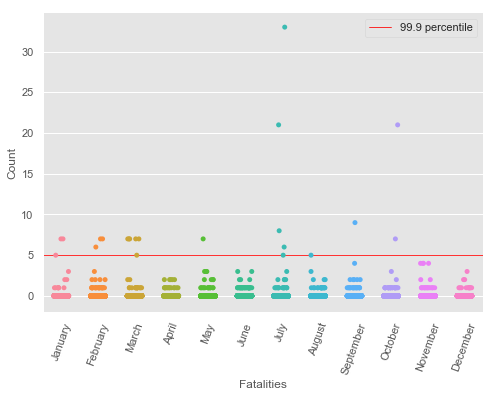

In [53]:
# Plot of outliers by column
numeric_columns= ['Hospitalizations',"Illnesses","Fatalities"]
for column in numeric_columns:
    outliers_by_month(column)

In [ ]:
def without_outliers(column,threshold=99.9, fatalities_threshold=99.95):
    # Plot of number of outbreaks by month without outliers
    # Fatalities are very skew, so, let us take a greater threshold
    if column == "Fatalities":
        threshold = fatalities_threshold
    # Column without outliers 
    no_outliers=outbreaks[outbreaks[column] <np.percentile(outbreaks[column],threshold)]
    # Plot
    sns.catplot(x="Month", y=column,jitter=0.2,height=5.0, aspect=7/5.0,data=no_outliers);
    # plot labels
    plt.xticks(rotation=70);
    plt.xlabel("Months");
    plt.ylabel(column);
    plt.title(column + " by month without outliers")
    
# # Plot of count without outliers
for column in numeric_columns:
    without_outliers(column,threshold=99.9)


In [55]:
def not_outliers_column(data, train_data, column,threshold=99.9):
    # Remove outliers caused by the column
    # Params:
    
    # data is the dataframe
    # train_data is used to calculate the threshold value for column
    # column is our column 
    
    #Return:
    #column without outliers
    
    # Check if column= Fatalities
    if column == "Fatalities":
        thr = 99.95
    else:
        thr = threshold
    # column without outliers   
    return (data[column] < np.percentile(train_data[column],thr))

In [ ]:
# Columns used to remove outliers
features = ["Hospitalizations","Fatalities","Illnesses"]
# deepcopy to keep the original dataframe(outbreaks) unchanged
not_outliers_outbreaks = copy.deepcopy(outbreaks)
for feature in features:
    without_outliers= not_outliers_column(not_outliers_outbreaks, not_outliers_outbreaks, feature,threshold=99.9)
    not_outliers_outbreaks= not_outliers_outbreaks.loc[without_outliers,:]
    
not_outliers_outbreaks.info()

In [57]:
# Save machine learning ready  dataset
not_outliers_outbreaks.to_csv('machine_learning_ready.csv',index=False) 